
# Tổng quan

Trong lĩnh vực xử lý ảnh và video thì bài toán khôi phục ảnh/video (image/video restoration) là một trong những bài toán quan trọng và có ứng dụng rộng rãi trong các lĩnh vực khoa học, kĩ thuật, y sinh v.v. Nhóm bài toán
khôi phục ảnh/video có thể được phân ra làm các dạng: bài toán khử nhiễu (image/video denoising), bài toán khử nhòa (image/video deblurring), bài toán khôi phục thông tin bị mất (image/video inpainting). Một số dạng bài toán như tăng/giảm độ phân giải cho ảnh/video để hiển thị trên các kích thước màn hình khác nhau (upsampling,
downsampling), phóng đại ảnh/video (image/video zooming) v.v. cũng có thể được xếp vào dạng bài toán khôi phục
bởi trong quá trình thực thi các tác vụ phóng to, thu nhỏ, tăng/giảm độ phân giải sẽ làm cho cấu trúc thông tin lưu trữ trên ảnh/video bị thay đổi hoặc bị mất.

Trong thực tế, các ảnh kĩ thuật số cũng như video kĩ thuật số được tạo ra thường chứa nhiễu. Có khá nhiều
nguyên nhân tạo ra nhiễu trong trường hợp này: do điều kiện thiếu sáng, hiệu chỉnh thông số ISO quá cao, do chất
lượng của các cảm biến, do nhiệt độ môi trường cao v.v. Trong quá trình truyền tải thông tin, các ảnh và video được truyền tải trên một đường truyền không đảm bảo cũng sẽ làm cho một phần thông tin trên ảnh hoặc video bị mất và tạo ra nhiễu. Trường hợp này được gọi là nhiễu do tính hiệu đường truyền. Trong bất kì trường hợp nào, nhiễu cũng sẽ làm giảm chất lượng của ảnh và video kĩ thuật số. Do đó, cần thiết phải loại bỏ nó.

Trong báo cáo này, nhóm nghiên cứu sẽ tiến hành mô hình hóa bài toán giảm nhiễu của ảnh dưới dạng một bài toán tối ưu lồi, thử nghiệm việc áp dụng 2 giải thuật Gradient Descent và Accelerated Gradient Descent để giải quyết bài toán này, đánh giá hiệu quả của 2 giải thuật và tác động của các siêu tham số (hyperparameter) của mô hình đối với hiệu quả của bài toán giảm nhiễu.

Bài báo cáo được trình bày với bố cục như sau. Trong phần tiếp theo, nhóm giới thiệu về các ký hiệu được sử dụng. Trong phần 3, nhóm trình bày về mô hình hóa bài toán khử nhiễu ảnh . Trong phần 4, nhóm trình bày về việc sử dụng 2 giải thuật Gradient Descent và Accelerated Gradient Descent trong việc giải quyết bài toán. Phần triển khai thuật toán và diễn giải kết quả được trình bày trong phần 5 và 6. Và cuối cùng là kết luận được đưa ra trong phần 7.   

# Các ký hiệu được sử dụng

Để tiện cho việc theo dõi nội dung nghiên cứu được trình bày phía dưới, nhóm sẽ giới thiệu ngắn gọn các ký hiệu được sử dụng trong bài nghiên cứu.

Ta ký hiệu 1 ảnh đen trắng dưới dạng 1 ma trận $u \in R^{NxN}$ với $N$ là kích thước chiều ngang/dọc của bức ảnh (ảnh vuông). Cường độ của bức ảnh tại tọa độ $(i, j)$ được ký hiệu là $u_{ij} \in R$. 

Với ma trận $u \in R^{NxN}$ cho trước, ta định nghĩa chuẩn theo phần tử của $u$ như sau:

$$||u||_2 = \sqrt{\sum(u_{ij}^2)}$$

Gradient của hàm L tính theo biến u được ký hiệu bởi: $\nabla L(u)$

Gradient $\nabla u$ tại vị trí $(i,j)$ được cho bởi:
$$(\nabla u)_{ij} = \big((\nabla u)^x_{ij}, (\nabla u)^x_{ij}\big)$$
trong đó:
$$(\nabla u)^x_{ij} = \begin{cases} u_{i+1, j} - u_{i,j}, & \mbox{if } i < N \\ 0, & \mbox{if } i=N \end{cases}$$

$$(\nabla u)^y_{ij} = \begin{cases} u_{i, j+1} - u_{i,j}, & \mbox{if } j < N \\ 0, & \mbox{if } j=N \end{cases}$$
với $i,j = 1, ..., N$

Divergence giữa 2 ma trận $u_x$, $u_y$ với $u_x, u_y \in R^{NxN}$ là một ma trận $D\in R^{NxN}$ được định nghĩa bởi:
$$D_{ij} = (div(u_x, u_y))_{ij} = \begin{cases} (u_x)_{i,j} - (u_x)_{i-1,j} &\mbox{if }1<i<N \\ (u_x)_{ij} &\mbox{if } i = 1 \\ -(u_x)_{i-1,j} &\mbox{if }i=N \end{cases} + \begin{cases} (u_y)_{i,j} - (u_y)_{i,j-1} &\mbox{if }1<i<N \\ (u_y)_{ij} &\mbox{if } i = 1 \\ -(u_y)_{i,j-1} &\mbox{if }i=N \end{cases}$$








# Mô hình hóa bài toán khử nhiễu

Mục tiêu của bài toán đặt ra là giảm nhiễu cho bức ảnh trong khi vẫn phải giữ chi tiết cho bức ảnh. Đặt $u_1 \in R^{NxN}$ là ma trận biểu diễn bức ảnh sau kết quả, $u_2 \in R^{NxN}$ là ma trận bức ảnh nhiễu ban đầu, ta có thể tiến hành mô hình hóa bài toán khử nhiễu bằng 1 hàm $L(u_1, u_2)$ như sau:
$$L(u_1, u_2) = L^{(1)}(u_1, u_2) + \lambda L^{(1)}(u_1)$$

Trong đó $L^{(1)}(u_1,u_2)$ thể hiện sự sai khác giữa bức ảnh ban đầu (có nhiễu) và bức ảnh kết quả, $L^{(2)}(u_1)$ thể hiện mức độ nhiễu trong bức ảnh kết quả, $\lambda$ thể hiện mức độ giảm nhiễu mà ta muốn.

Đối với hàm $L^{(1)}(u_1, u_2)$, trong bài báo cáo này, nhóm tiến hành mô hình hóa như sau:
$$L^{(1)}(u_1,u_2) = ||u_1-u_2||_2^2$$
Đối với hàm $L^{(2)}(u_1)$, qua việc phân tích các nghiên cứu trước đây về bài toán khử nhiễu, nhóm sử dụng 2 mô hình để thể hiện mức độ nhiễu trong bức ảnh:
$$L^{(2)}(u_1) = ||\nabla u_1||_2^2$$
$$L^{(2)'}(u_1) = ||\nabla u_1||_2$$



Ta có: $$\nabla L_{u_1}(u_1, u_2) = \nabla L^{(1)}_{u_1}(u_1, u_2) + \nabla L^{(2)}_{u_1}(u_1)$$




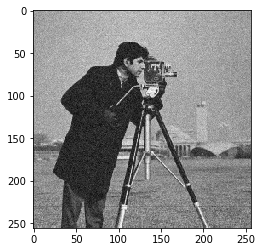

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def divergence(f):
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], axis=i) for i in range(num_dims)])

img = plt.imread("./cameraman.png")
img_noise = img + np.random.randn(*img.shape)*0.05
plt.imshow(img_noise, cmap='gray')
plt.show()

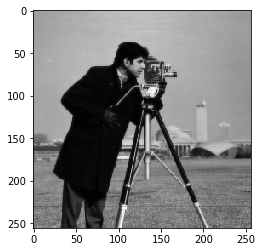

In [5]:
tau=0.1;
lmbda = 0.5;
u=img_noise;
for k in range(20):
    ux, uy = np.gradient(u)
    u = u - tau * (u - img - lmbda * divergence([ux, uy]))

plt.imshow(u, cmap= 'gray')
plt.show()